# A Neural Network for Regression (Estimate blood pressure from PPG signal)

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [HW page](http://kovan.ceng.metu.edu.tr/~sinan/DL/index.html) on the course website.*

Having gained some experience with neural networks, let us train a network that estimates the blood pressure from a PPG signal window.

All of your work for this exercise will be done in this notebook.

# A Photoplethysmograph (PPG) signal

A PPG (photoplethysmograph) signal is a signal obtained with a pulse oximeter, which illuminates the skin and measures changes in light absorption. A PPG signal carries rich information about the status of the cardiovascular health of a person, such as breadth rate, heart rate and blood pressure. An example is shown below, where you also see the blood pressure signal that we will estimate (the data also has the ECG signal, which you should ignore).

<img width="80%" src="PPG_ABG_ECG_example.png">


# Constructing the Dataset 

In this task, you are expected to perform the full pipeline for creating a learning system from scratch. Here is how you should construct the dataset:
* Download the dataset from the following website, and only take "Part 1" from it (it is too big): https://archive.ics.uci.edu/ml/datasets/Cuff-Less+Blood+Pressure+Estimation
* Take a window of size $W$ from the PPG channel between time $t$ and $t+W$. Let us call this $\textbf{x}_t$.
* Take the corresponding window of size $W$ from the ABP (arterial blood pressure) channel between time $t$ and $t+W$. Find the maxima and minima of this signal within the window (you can use "findpeaks" from Matlab or "find_peaks_cwt" from scipy). Here is an example window from the ABP signal, and its peaks:
 <img width="60%" src="ABP_peaks.png">
    
* Calculate the average of the maxima, call it $y^1_t$, and the average of the minima, call it $y^2_t$.
* Slide the window over the PPG signals and collect many $(\textbf{x}_t, <y^1_t, y^2_t>)$ instances. In other words, your network outputs two values.
* This will be your input-output for training the network.

In [89]:
import random
import numpy as np
from metu.data_utils import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.
from cs231n.classifiers.neural_net_for_regression import TwoLayerNet

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
  np.random.seed(0)
  return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
  np.random.seed(1)
  X = 10 * np.random.randn(num_inputs, input_size)
  y = np.array([[0, 1, 2], [1, 2, 3], [2, 3, 4], [2, 1, 4], [2, 1, 4]])
  return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Open the file `cs231n/classifiers/neural_net_for_regression.py` and look at the method `TwoLayerNet.loss`. This function is very similar to the loss functions you have written for the previous exercises: It takes the data and weights and computes the *regression* scores, the squared error loss, and the gradients on the parameters. 

To be more specific, you will implement the following loss function:

$$\frac{1}{2}\sum_i\sum_{j} (o_{ij} - y_{ij})^2 + \frac{1}{2}\lambda\sum_j w_j^2,$$

where $i$ runs through the samples in the batch; $o_{ij}$ is the prediction of the network for the $i^{th}$ sample for output $j$, and $y_{ij}$ is the correct value; $\lambda$ is the weight of the regularization term.

The first layer uses ReLU as the activation function. The output layer does not use any activation functions.

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [91]:
scores = net.loss(X, dropout = 1.0)
print 'Your scores:'
print scores
print
print 'correct scores:'
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print correct_scores
print

# The difference should be very small. We get < 1e-7
print 'Difference between your scores and correct scores:'
print np.sum(np.abs(scores - correct_scores))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720496109664e-08


# Forward pass: compute loss
In the same function, implement the second part that computes the data and regularizaion loss.

In [92]:
loss, _ = net.loss(X, y, reg=0.1, dropout=1.0)
correct_loss = 66.3406756909

# should be very small, we get < 1e-10
print 'Difference between your loss and correct loss:'
print np.sum(np.abs(loss - correct_loss))

Difference between your loss and correct loss:
2.5480062504357193e-11


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [93]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.1, dropout=1.0)

# these should all be less than 1e-8 or so
for param_name in grads:
  f = lambda W: net.loss(X, y, reg=0.1, dropout=1.0)[0]
  param_grad_num = eval_numerical_gradient(f, net.params[param_name])
  print '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))

W1 max relative error: 5.463838e-04
W2 max relative error: 3.755046e-04
b2 max relative error: 1.443387e-06
b1 max relative error: 2.188996e-07


# Load the PPG dataset for training your regression network

In [173]:
# Load the PPG dataset
# If your memory turns out to be sufficient, try loading a subset
import os
def get_data(datafile, training_ratio=0.8, test_ratio=0.12, val_ratio=0.08):
  # Load the PPG training data 

  X, y = load_dataset(datafile)
  
  '''
  X = np.load("long_in.npy")
  y = np.load("long_out.npy")
  '''
  '''
  X = np.load("single_std_in.npy")
  y = np.load("single_std_out.npy")
  
  X = np.load("rand_st_in.npy")
  y = np.load("rand_st_out.npy")
  '''
  
  np.random.seed(0)
  np.random.shuffle(y)
  np.random.seed(0)
  np.random.shuffle(X)

  # TODO: Split the data into training, validation and test sets
  length=len(y)
  num_training=int(length*training_ratio)
  num_val = int(length*val_ratio)
  num_test = min((length-num_training-num_val), int(length*test_ratio))
  mask = range(num_training-1)
  X_train = X[mask]
  y_train = y[mask]
  mask = range(num_training, num_training+num_test)
  X_test = X[mask]
  y_test = y[mask]
  mask = range(num_training+num_test, num_training+num_test+num_val)
  X_val = X[mask]
  y_val = y[mask]
  return X_train, y_train, X_val, y_val, X_test, y_test
cwd = os.getcwd()
datafile = cwd  + '/metu/dataset/Part_1.mat'
#datafile = 'metu/dataset/part1_dataset.mat' #TODO: PATH to your data file
input_size = 1000 # TODO: Size of the input of the network

X_train, y_train, X_val, y_val, X_test, y_test = get_data(datafile)
print "Number of instances in the training set: ", len(X_train)
print "Number of instances in the validation set: ", len(X_val)
print "Number of instances in the testing set: ", len(X_test)

Number of instances in the training set:  23676
Number of instances in the validation set:  2367
Number of instances in the testing set:  3551


# Overfitting on a tiny set

In [321]:
from cs231n.classifiers.three_layer_net_for_regression import ThreeLayerNet

tiny_fitter = ThreeLayerNet(input_size, [400,100], 2)


# Train the network
stats = tiny_fitter.train(X_train[:3], y_train[:3], X_train[:3], y_train[:3],
            num_iters=2500, batch_size=3, dropout=1.0, momentum=0.9,
            learning_rate=1e-6, learning_rate_decay=1.0,
            reg=0.0, verbose=True)

# Predict on the validation set
#val_err = ... # TODO: Perform prediction on the validation set
y_pred_train = tiny_fitter.predict(X_train[:3])
train_err = np.sum(np.square(y_pred_train - y_train[:3]), axis=1).mean()

print
print 'train error: ', train_err
print

print y_train[:3]
print y_pred_train

iteration 0 / 2500: loss 24812.250074
iteration 100 / 2500: loss 21871.663668
iteration 200 / 2500: loss 18935.398406
iteration 300 / 2500: loss 26052.586229
iteration 400 / 2500: loss 33130.058803
iteration 500 / 2500: loss 35710.504353
iteration 600 / 2500: loss 28327.942187
iteration 700 / 2500: loss 32596.790524
iteration 800 / 2500: loss 30730.188100
iteration 900 / 2500: loss 26148.797062
iteration 1000 / 2500: loss 23278.686058
iteration 1100 / 2500: loss 27517.681473
iteration 1200 / 2500: loss 31730.059124
iteration 1300 / 2500: loss 27199.790824
iteration 1400 / 2500: loss 29716.269166
iteration 1500 / 2500: loss 17197.890625
iteration 1600 / 2500: loss 5538.944007
iteration 1700 / 2500: loss 7170.788001
iteration 1800 / 2500: loss 814.704278
iteration 1900 / 2500: loss 22.880757
iteration 2000 / 2500: loss 38.002809
iteration 2100 / 2500: loss 25.853388
iteration 2200 / 2500: loss 18.149809
iteration 2300 / 2500: loss 40.904985
iteration 2400 / 2500: loss 31.229456

train er

# Now train our network on the PPG dataset

In [218]:
# Now, let's train a neural network
# 3 Layer net
from cs231n.classifiers.three_layer_net_for_regression import ThreeLayerNet

input_size = input_size
hidden_size = 700
hidden_sizes = [700, 400] # TODO: Choose a suitable hidden layer size
num_classes = 2 # We have two outputs

net = ThreeLayerNet(input_size, hidden_sizes, num_classes)
#net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=5000, batch_size=128, dropout=0.9,
            learning_rate=1e-6, learning_rate_decay=1,
            reg=0.001, verbose=True)

# Predict on the validation set
#val_err = ... # TODO: Perform prediction on the validation set
y_pred_train = net.predict(X_train)
train_err = np.sum(np.square(y_pred_train - y_train), axis=1).mean()

y_pred_val = net.predict(X_val)
y_pred_test = net.predict(X_test)
val_err = np.sum(np.square(y_pred_val - y_val), axis=1).mean()
test_err = np.sum(np.square(y_pred_test - y_test), axis=1).mean()

print
print 'train/val/test error: ', train_err , val_err, test_err
print

idx = np.random.choice(y_val.shape[0], 5)
print y_val[idx]
print y_pred_val[idx]

iteration 0 / 15000: loss 1212843.149191
iteration 100 / 15000: loss 965337.149450
iteration 200 / 15000: loss 737560.241382
iteration 300 / 15000: loss 616308.575468
iteration 400 / 15000: loss 489871.621735
iteration 500 / 15000: loss 394037.408788
iteration 600 / 15000: loss 283531.736740
iteration 700 / 15000: loss 223919.277927
iteration 800 / 15000: loss 187610.349296
iteration 900 / 15000: loss 168051.590669
iteration 1000 / 15000: loss 121951.975180
iteration 1100 / 15000: loss 108500.967042
iteration 1200 / 15000: loss 92259.021854
iteration 1300 / 15000: loss 67599.021720
iteration 1400 / 15000: loss 62086.911528
iteration 1500 / 15000: loss 60027.743975
iteration 1600 / 15000: loss 48387.978161
iteration 1700 / 15000: loss 42487.272690
iteration 1800 / 15000: loss 64803.094544
iteration 1900 / 15000: loss 43204.780335
iteration 2000 / 15000: loss 41289.677119
iteration 2100 / 15000: loss 42019.240178
iteration 2200 / 15000: loss 39803.568316
iteration 2300 / 15000: loss 3710

KeyboardInterrupt: 

# Debug the training and improve learning
You should be able to get a validation error of 5.

So far so good. But, is it really good? Let us plot the validation and training errors to see how good the network did. Did it memorize or generalize? Discuss your observations and conclusions. If its performance is not looking good, propose and test measures. This is the part that will show me how well you have digested everything covered in the lectures.

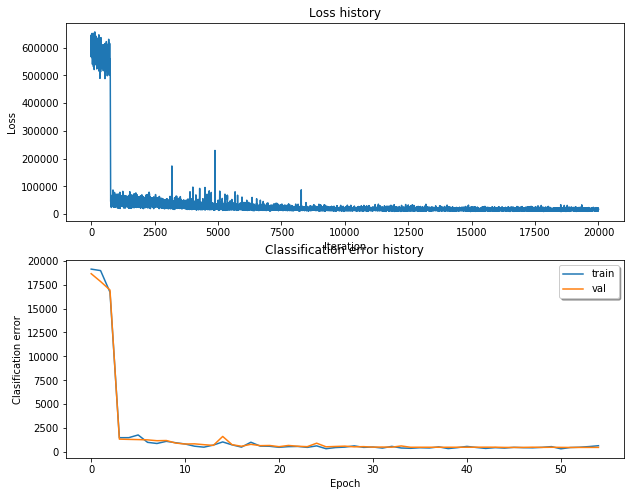

In [209]:
# Plot the loss function and train / validation errors
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
train = plt.plot(stats['train_err_history'], label='train')
val = plt.plot(stats['val_err_history'], label='val')
plt.legend(loc='upper right', shadow=True)
plt.title('Classification error history')
plt.xlabel('Epoch')
plt.ylabel('Clasification error')
plt.show()

# Finetuning and Improving Your Network (Bonus)
There are many aspects and hyper-parameters you can play with. Do play with them and find the best setting here.

In [200]:
best_net = None

results = {}
best_val = float("inf")

batch_sizes = [32, 64, 128]
dropout_probs = [0.5, 1.0]
learning_rates = [1e-5,1e-6, 5e-7, 1e-7]
regularization_strengths = [5e-1,1e-3, 0.0]
k=0
while k<len(batch_sizes):
    i=0
    while i< len(learning_rates):
        j = 0
        while j < len(regularization_strengths):    
            d = 0
            while d < len(dropout_probs):
                print 'bs:',batch_sizes[k], "lr:", learning_rates[i], "rg:", regularization_strengths[j], 'dr:', dropout_probs[d]
                
                net = ThreeLayerNet(input_size, [500,300], num_classes)
                stats = net.train(X_train, y_train, X_val, y_val,
                    num_iters=3000, batch_size=batch_sizes[k], dropout=dropout_probs[d],
                    learning_rate=learning_rates[i], learning_rate_decay=0.95,
                    reg=regularization_strengths[j])
                val_err = np.sum(np.square(net.predict(X_val) - y_val), axis=1).mean()
                train_err = np.sum(np.square(net.predict(X_train) - y_train), axis=1).mean()
                
                print 'train/val err:',train_err, val_err
                if best_val > val_err:
                    best_val = val_err
                    best_net = net
                results[(batch_sizes[k],learning_rates[i], regularization_strengths[j], dropout_probs[d])] = (train_err, val_err)
                print
                d=d+1
            j=j+1
        i=i+1
    k=k+1

print 'best validation error achieved during cross-validation: %f' % best_val

test_error = np.sum(np.square(best_net.predict(X_test) - y_test), axis=1).mean()
print 'Test error: ', test_error


bs: 32 lr: 1e-05 rg: 0.5 dr: 0.5
train/val err: 566.6332003759806 562.0242200682388

bs: 32 lr: 1e-05 rg: 0.5 dr: 1.0
train/val err: 566.5962689612354 562.2851977891905

bs: 32 lr: 1e-05 rg: 0.001 dr: 0.5
train/val err: 571.6366592864364 570.9782198810125

bs: 32 lr: 1e-05 rg: 0.001 dr: 1.0
train/val err: 566.6017455349102 562.3707172733087

bs: 32 lr: 1e-05 rg: 0.0 dr: 0.5
train/val err: 566.6852384305731 562.8515455774327

bs: 32 lr: 1e-05 rg: 0.0 dr: 1.0
train/val err: 567.8725726108629 562.2554808083893

bs: 32 lr: 1e-06 rg: 0.5 dr: 0.5
train/val err: 563.8613021983213 563.0019774258633

bs: 32 lr: 1e-06 rg: 0.5 dr: 1.0
train/val err: 551.3983697520571 543.7521959911569

bs: 32 lr: 1e-06 rg: 0.001 dr: 0.5
train/val err: 596.8335043303956 602.6473569731916

bs: 32 lr: 1e-06 rg: 0.001 dr: 1.0
train/val err: 551.1226276823005 543.5266325930113

bs: 32 lr: 1e-06 rg: 0.0 dr: 0.5
train/val err: 546.5618766307459 541.3965484768689

bs: 32 lr: 1e-06 rg: 0.0 dr: 1.0
train/val err: 617.75070

KeyboardInterrupt: 


# Discussion

I have tried several architectures with 2 and 3 layers with different learning rates, regularizations strengths, dropout rates etc. I was always stuck in a local minima. I have also tried to collect to data with different strides and randomizations. Those did not help as well. I could not even achieved 0.0 loss in tiny subsets of the data with sizes of 3, 5, 10, and 20. 

Only way I can tell it works is I could achieve 0.0 loss with 2 data points. Other than that no mentionable results. 